In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.models import Sequential,load_model
from keras.layers import Dense,LSTM,Embedding,Dropout
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support
import re
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE

In [2]:
# Reading Intent Dataset

In [3]:
data=pd.read_csv('intent12-corrected.csv',delimiter = ';',names=['Text','Intent'],encoding="utf-8")
data.sample(frac=1).reset_index(drop=True)
print(data.shape)
data.head()

(10561, 2)


,Text,Intent
0,Kiyyoo dirama oso eguti jirun na darbe tari a...,Question
1,Meeti ree kuta 28ffaa,Question
2,Kutaa digdami sadetaffa isiin egee dadhabee.,Negative
3,Kutaa digdami sadetaffaa fiidagaa maali nuuraa...,Negative
4,Nuuf jabbadhakaa warii Akka kotti kiyyoo jaala...,Positive


<AxesSubplot:xlabel='Intent', ylabel='count'>

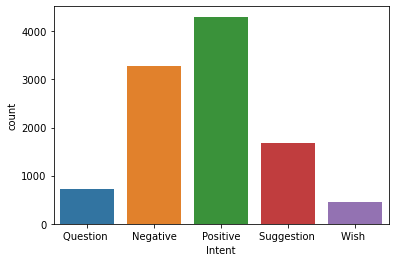

In [4]:
sns.countplot(x='Intent', data=data)

In [5]:
data["Intent"].value_counts()
#print(len('Gosa_miira'))
#print(len('jechoota'))

Positive       4301
Negative       3271
Suggestion     1686
Question        718
Wish            454
Name: Intent, dtype: int64

# Data Preprocessing

In [6]:
def preprocess_text(sen):
    # Removing html tags
    sentence = remove_tags(sen)
    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)
    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)
    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)
    sentence = sen.lower()
    sentence = re.sub(r'wo*w','wow', sentence)
    sentence = re.sub(r'uu*f','uff', sentence)
    return sentence
TAG_RE = re.compile(r'<[^>]+>')
def remove_tags(Text):
    return TAG_RE.sub('', Text)

In [7]:
def remove_stopwords(review_words):
    with open('stopwords.txt')as stopfile:
        stopwords=stopfile.read()
        list=stopwords.split()
        print(list)
        with open("intent1.csv") as workfile:
            read_data=workfile.read()
            data=read_data.split()
            print(data)
            for word1 in list:
                for word2 in data:
                    if word1==word2:
                        return data.remove(list)
                        print(remove_stopwords)

In [8]:
data['Text'].apply(lambda x: x.lower())

0        kiyyoo dirama oso  eguti jirun na darbe tari a...
1                                    meeti ree kuta 28ffaa
2             kutaa digdami sadetaffa isiin egee dadhabee.
3        kutaa digdami sadetaffaa fiidagaa maali nuuraa...
4        nuuf jabbadhakaa warii akka kotti kiyyoo jaala...
                               ...                        
10556    isheenis namoota dogoggoraa waliin lafa dogogg...
10557    vidiyichis battalumatti qoodamuun marsariitiiw...
10558    gochiwwan qaamaa warraabbicha irratti ture bah...
10559              jechi gurbbichaa altokkicha dhagahame. 
10560                           viidiyoo waraabaa jirtaa? 
Name: Text, Length: 10561, dtype: object

# Feature Extraction

In [9]:
tokenizer=Tokenizer(num_words=4000,split=" ")
tokenizer.fit_on_texts(data['Text'].values)
x=tokenizer.texts_to_sequences(data['Text'].values)
x=pad_sequences(x)
x[:5]

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,  198, 3008, 3009,
          37,  194,  146,  325],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,  432, 3297],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
         159, 3298,  319,  413],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,  159,
        3298,  154, 3094,   46],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,   75, 3299,
           4, 3095,  198, 3300]])

In [10]:
model = Sequential()
model.add(Embedding(4000, 128, input_length=x.shape[1]))
model.add(Dropout(0.2))
model.add(LSTM(100, return_sequences=True, dropout=0.5, recurrent_dropout=0.2))
model.add(LSTM(100, dropout=0.3, recurrent_dropout=0.2))
#model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.3))
model.add(Dense(5, activation = 'softmax'))

In [11]:
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 26, 128)           512000    
                                                                 
 dropout (Dropout)           (None, 26, 128)           0         
                                                                 
 lstm (LSTM)                 (None, 26, 100)           91600     
                                                                 
 lstm_1 (LSTM)               (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 5)                 505       
                                                                 
Total params: 684,505
Trainable params: 684,505
Non-trainable params: 0
_________________________________________________________________


In [13]:
y=pd.get_dummies(data['Intent']).values
[print(data['Intent'][i],y[i]) for i in range(0,5)]

Question  [0 0 1 0 0]
Question  [0 0 1 0 0]
Negative [1 0 0 0 0]
Negative [1 0 0 0 0]
Positive [0 1 0 0 0]


[None, None, None, None, None]

# Splitting Traing and Testing Dataset

In [14]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state=10)

# Training the Model

In [15]:
ros = SMOTE(random_state=100)
X_train_ros, y_train_ros = ros.fit_resample(x, y)

In [16]:
batch_size = 128
epochs = 30
history = model.fit(X_train_ros, y_train_ros, epochs=epochs, batch_size=batch_size,validation_split=0.2, verbose=2)

Epoch 1/30
135/135 - 28s - loss: 1.3506 - accuracy: 0.3917 - val_loss: 3.2236 - val_accuracy: 0.0600 - 28s/epoch - 209ms/step
Epoch 2/30
135/135 - 27s - loss: 0.8399 - accuracy: 0.6868 - val_loss: 3.0982 - val_accuracy: 0.0821 - 27s/epoch - 197ms/step
Epoch 3/30
135/135 - 26s - loss: 0.6591 - accuracy: 0.7574 - val_loss: 2.6142 - val_accuracy: 0.2034 - 26s/epoch - 193ms/step
Epoch 4/30
135/135 - 27s - loss: 0.5542 - accuracy: 0.7990 - val_loss: 3.2662 - val_accuracy: 0.2769 - 27s/epoch - 198ms/step
Epoch 5/30
135/135 - 27s - loss: 0.4880 - accuracy: 0.8179 - val_loss: 3.8845 - val_accuracy: 0.2646 - 27s/epoch - 203ms/step
Epoch 6/30
135/135 - 27s - loss: 0.4405 - accuracy: 0.8385 - val_loss: 4.0699 - val_accuracy: 0.2990 - 27s/epoch - 197ms/step
Epoch 7/30
135/135 - 27s - loss: 0.4051 - accuracy: 0.8510 - val_loss: 4.0001 - val_accuracy: 0.2976 - 27s/epoch - 201ms/step
Epoch 8/30
135/135 - 26s - loss: 0.3753 - accuracy: 0.8629 - val_loss: 4.3450 - val_accuracy: 0.3090 - 26s/epoch - 194

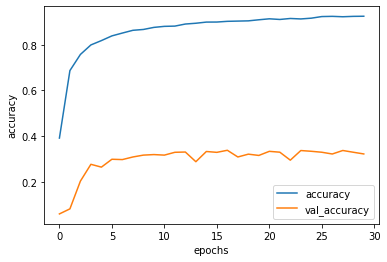

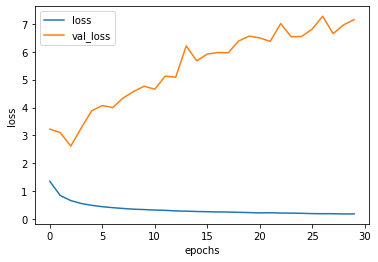

In [17]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

# Testing The model

In [18]:
predictions = model.predict(x_test)

67/67 [==============================] - 1s 9ms/step


In [19]:
scores = model.evaluate(x_test, y_test,verbose=2)

print(scores)

67/67 - 1s - loss: 0.1314 - accuracy: 0.9375 - 1s/epoch - 18ms/step
[0.1314096599817276, 0.9375295639038086]


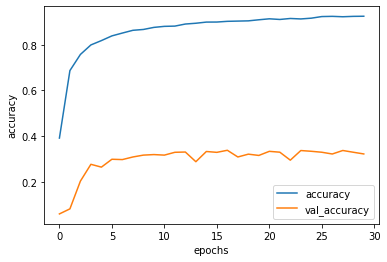

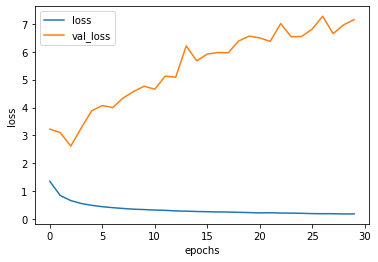

In [20]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [21]:
model.save("Intent_Classification_using_LSTM.h5")

In [22]:
new_intent = ['Maliif nurraa turtan garuu?']
seq = tokenizer.texts_to_sequences(new_intent)
padded = pad_sequences(seq, maxlen=6000)
pred = model.predict(padded)
Intent = ['Positive', 'Negative', 'Suggestion', 'Question', 'Wish']
print(pred, Intent[np.argmax(pred)])

1/1 [==============================] - 1s 1s/step
[[8.1023183e-03 4.2709389e-06 9.9105388e-01 8.3935406e-04 1.7643238e-07]] Suggestion


In [23]:
[print (data['Text'][i], predictions[i], y_test[i]) for i in range(0, 200)]

Kiyyoo dirama oso  eguti jirun na darbe tari ayaana moo sababa godhatu moyuu [7.1028699e-05 9.9935061e-01 3.2442644e-05 5.4524088e-04 5.3716559e-07] [0 1 0 0 0]
Meeti ree kuta 28ffaa [9.9812025e-01 4.1222316e-05 1.8323354e-03 6.0471157e-06 1.1469401e-07] [1 0 0 0 0]
Kutaa digdami sadetaffa isiin egee dadhabee. [1.0568609e-02 4.7284004e-04 1.7753853e-05 6.0676700e-03 9.8287314e-01] [0 0 0 0 1]
Kutaa digdami sadetaffaa fiidagaa maali nuuraa tuursiftaani bar ani 1faa haanga 27faa haarfoofan tuuree [3.2955353e-04 9.9790120e-01 7.9127360e-04 6.4224715e-04 3.3575515e-04] [0 1 0 0 0]
Nuuf jabbadhakaa warii Akka kotti kiyyoo jaalatan  [9.99460518e-01 3.96978983e-04 1.10353154e-04 3.12595403e-05
 8.98853557e-07] [1 0 0 0 0]
Bayyee namatti tola itti fufa gariidha  [3.3374510e-03 1.9495687e-05 9.9145234e-01 5.1902505e-03 4.8977904e-07] [0 0 1 0 0]
Diraamichi torbetti yeroo lamaa nuuf dhiyaachuu qaba [9.5326695e-06 9.9997187e-01 1.8341759e-06 1.2345759e-05 4.4259345e-06] [0 1 0 0 0]
Ani dhugaa dub

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

In [24]:
cm=metrics.confusion_matrix(y_test.argmax(axis=1), predictions.argmax(axis=1))

In [25]:
FP = cm.sum(axis=0) - np.diag(cm)  
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)

In [26]:
FP = FP.astype(float)
FN = FN.astype(float)
TP = TP.astype(float)
TN = TN.astype(float)

In [27]:
print(FP)
print(FN)
print(TP)
print(TN)

[28. 22. 38. 41.  3.]
[27. 70.  3. 22. 10.]
[628. 766. 171. 328.  88.]
[1430. 1255. 1901. 1722. 2012.]


In [28]:
accuracy=(TP+TN)/(TP+TN+FP+FN)
precision = TP/(TP+FP)
recall = TP/(TP+FN)
f1_score = 2*precision*recall/(precision+recall)

In [29]:
print("recall  ", recall)
print("precision",precision)
print("f1_score",f1_score)

recall   [0.95877863 0.91626794 0.98275862 0.93714286 0.89795918]
precision [0.95731707 0.97208122 0.81818182 0.88888889 0.96703297]
f1_score [0.95804729 0.94334975 0.89295039 0.9123783  0.93121693]


In [30]:
def accuracy(confusion_matrix):
    diagonal_sum = confusion_matrix.trace()
    sum_of_all_elements = confusion_matrix.sum()
    return diagonal_sum / sum_of_all_elements 

In [31]:
accuracy(cm)

0.9375295787979177

In [32]:
def precision(label, confusion_matrix):
    col = confusion_matrix[:, label]
    return confusion_matrix[label, label] / col.sum()
    
def recall(label, confusion_matrix):
    row = confusion_matrix[label, :]
    return confusion_matrix[label, label] / row.sum()

def precision_macro_average(confusion_matrix):
    rows, columns = confusion_matrix.shape
    sum_of_precisions = 0
    for label in range(rows):
        sum_of_precisions += precision(label, confusion_matrix)
    return sum_of_precisions / rows

def recall_macro_average(confusion_matrix):
    rows, columns = confusion_matrix.shape
    sum_of_recalls = 0
    for label in range(columns):
        sum_of_recalls += recall(label, confusion_matrix)
    return sum_of_recalls / columns

In [33]:
print("label precision recall")
for label in range(4):
    print(f"{label:5d} {precision(label, cm):9.3f} {recall(label, cm):6.3f}")

label precision recall
    0     0.957  0.959
    1     0.972  0.916
    2     0.818  0.983
    3     0.889  0.937


In [34]:
print("precision total:", precision_macro_average(cm))

print("recall total:", recall_macro_average(cm))

precision total: 0.9207003931097034
recall total: 0.9385814460087823


In [35]:
def accuracy(confusion_matrix):
    diagonal_sum = confusion_matrix.trace()
    sum_of_all_elements = confusion_matrix.sum()
    return diagonal_sum / sum_of_all_elements 

In [36]:
accuracy(cm)

0.9375295787979177